# Exploratory Data Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import random
import scipy.io as sio

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T


In [2]:
IMG1 = os.path.join("dataset", "lizard_images1", "Lizard_Images1")
IMG2 = os.path.join("dataset", "lizard_images2", "Lizard_Images2")
LABELS = os.path.join("dataset", "lizard_labels", "Lizard_Labels", "Labels")
INFO = os.path.join("dataset", "lizard_labels", "Lizard_Labels", "info.csv")
OVERLAY = os.path.join("dataset", "overlay", "Overlay")

# EDA

In [3]:
# info.csv
df = pd.read_csv(INFO)
df.head()

,Filename,Source,Split
0,dpath_1,1800127001_2019-04-30 10_40_02-lv1-1001-22444-...,3
1,dpath_2,1902160001_2019-06-11 12_36_32-lv1-39045-16016...,2
2,dpath_3,2019_03867_1-1_2019-02-20 20_00_32-lv1-35269-3...,3
3,dpath_4,2019-07501-1-1-1_2019-05-29 08_22_25-lv1-9661-...,1
4,dpath_5,2018_83220_1-1_2019-02-20 18_33_11-lv1-58151-3...,2


In [4]:
len(df)

238

> The dataset is already split into train, validatioan and test parts

In [5]:
# Count Images and Labels

images1 = sorted(glob(os.path.join(IMG1, "*.*")))
images2 = sorted(glob(os.path.join(IMG2, "*.*")))
labels_files = sorted(glob(os.path.join(LABELS, "*.*")))
overlay_files = sorted(glob(os.path.join(OVERLAY, "*.*")))

print("Images1:", len(images1))
print("Images2:", len(images2))
print("Labels:", len(labels_files))
print("Overlay:", len(overlay_files))

Images1: 80
Images2: 158
Labels: 238
Overlay: 238


> - The dataset (.png) is split into 2 folders 
> - All the labels (.mat) are located in one folder
> - Overlay files (.jpg) are also located in one folder

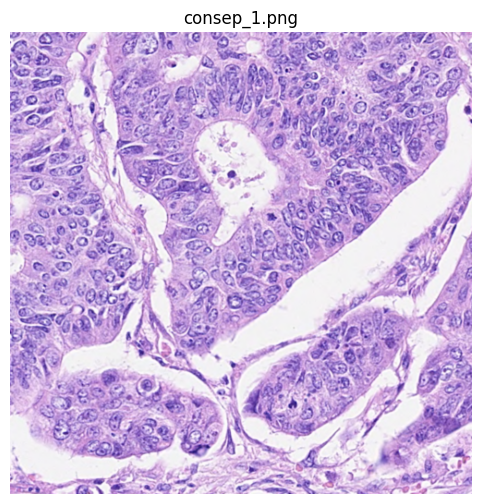

In [6]:
# Show Image

def show_image(path):
    img = np.array(Image.open(path))
    plt.figure(figsize=(6,6))
    plt.title(os.path.basename(path))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


show_image(images1[0])

dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'id', 'class', 'bbox', 'centroid'])


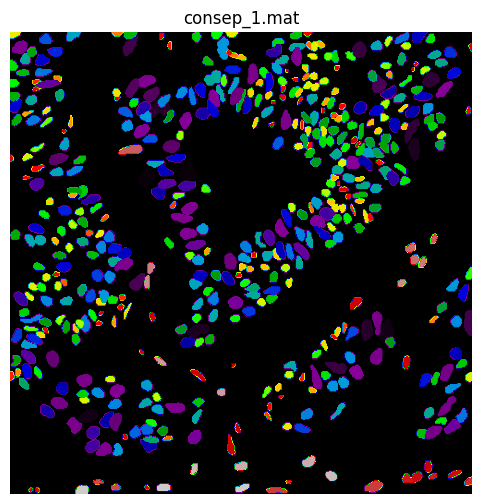

Nuclei in this image: 528


In [7]:
# Show Label

def show_label(path):
    mask_data = sio.loadmat(path)

    print(mask_data.keys())  # see what arrays are inside

    inst_map = mask_data['inst_map']  

    plt.figure(figsize=(6,6))
    plt.imshow(inst_map, cmap='nipy_spectral')
    plt.axis('off')
    plt.title(os.path.basename(path))
    plt.show()

    nuclei_count = len(np.unique(inst_map)) - 1  # subtract 0 (background)
    print("Nuclei in this image:", nuclei_count)


show_label(labels_files[0])

dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'id', 'class', 'bbox', 'centroid'])


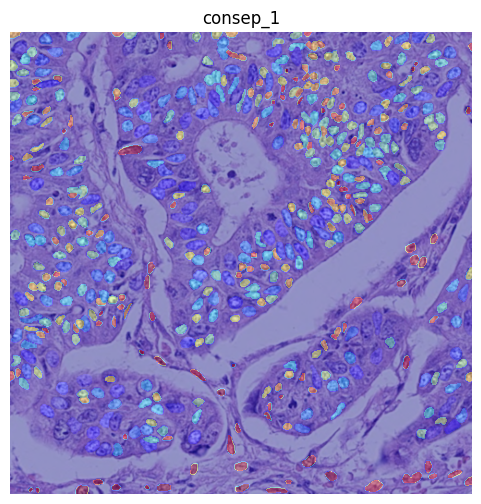

In [8]:
# Overlay Image and Mask

def overlay(img_path, mask_path):
    img = np.array(Image.open(img_path))

    mat = sio.loadmat(mask_path)
    
    print(mat.keys())  # first, to see what key holds your mask
    mask_key = [k for k in mat.keys() if not k.startswith('__')][0]  # take first non-meta key
    mask = mat[mask_key]

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.imshow(mask, alpha=0.4, cmap='jet')
    plt.title(os.path.basename(img_path).split('.')[0])
    plt.axis('off')
    plt.show()


overlay(images1[0], labels_files[0])


dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'id', 'class', 'bbox', 'centroid'])


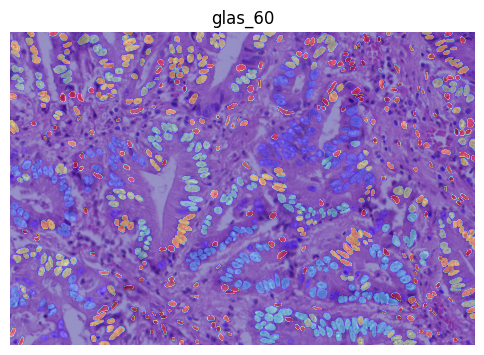

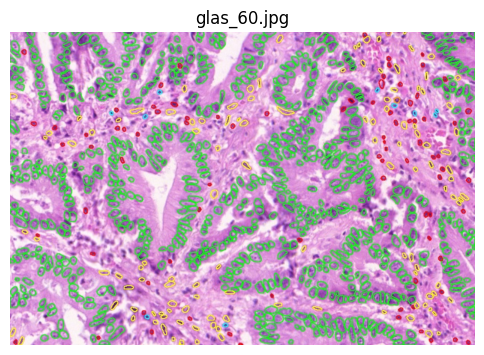

In [9]:
# Overlay random image to check constintancy

random_image = random.choice(images1 + images2)

def get_mask_path(img_path):
    img_name = os.path.basename(img_path).split('.')[0]
    mask_path = os.path.join(LABELS, img_name + ".mat")
    return mask_path

# Image + Label
overlay(random_image, get_mask_path(random_image))

# Overlay from dataset
overlay_img_path = os.path.join(OVERLAY, os.path.basename(random_image).split('.')[0] + ".jpg")
show_image(overlay_img_path)


> I ran this several times and didnt find any inconsistances between overlay files and coresponding combined image + mask

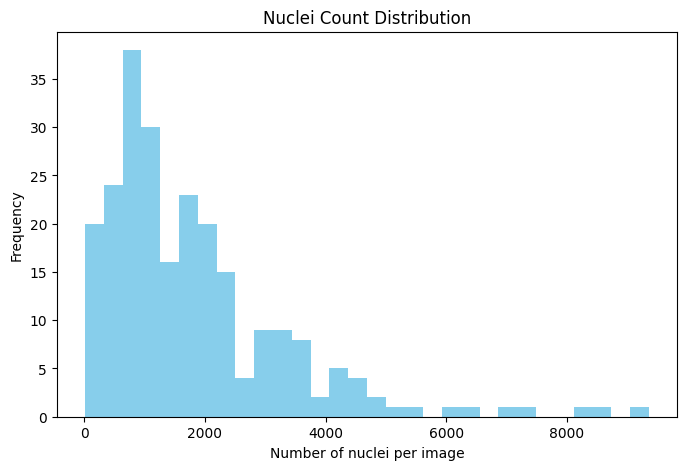

In [10]:
# Number of nuclei per image

nuclei_counts = []
for mask_path in labels_files:
    mat = sio.loadmat(mask_path)
    mask_key = [k for k in mat.keys() if not k.startswith('__')][0]
    mask = mat[mask_key]
    count = len(np.unique(mask)) - 1  # subtract background
    nuclei_counts.append(count)

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(nuclei_counts, bins=30, color='skyblue')
plt.xlabel("Number of nuclei per image")
plt.ylabel("Frequency")
plt.title("Nuclei Count Distribution")  
plt.show()

> There are some outliers (several images have too many nuclei compared to the others)

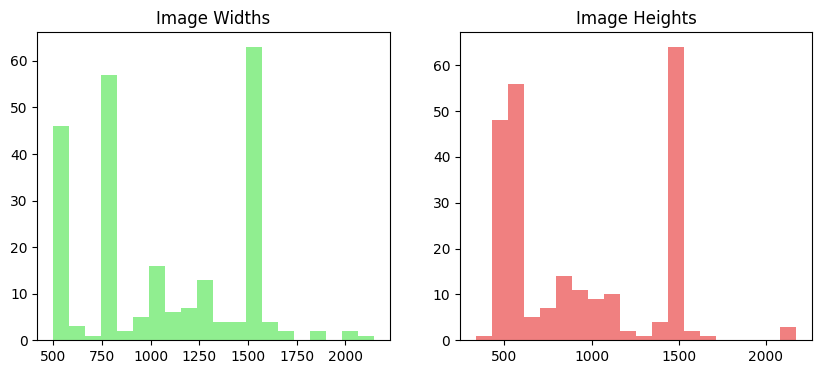

In [11]:
# Image Sizes

img_sizes = [Image.open(p).size for p in images1 + images2]
widths, heights = zip(*img_sizes)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(widths, bins=20, color='lightgreen')
plt.title("Image Widths")

plt.subplot(1,2,2)
plt.hist(heights, bins=20, color='lightcoral')
plt.title("Image Heights")
plt.show()


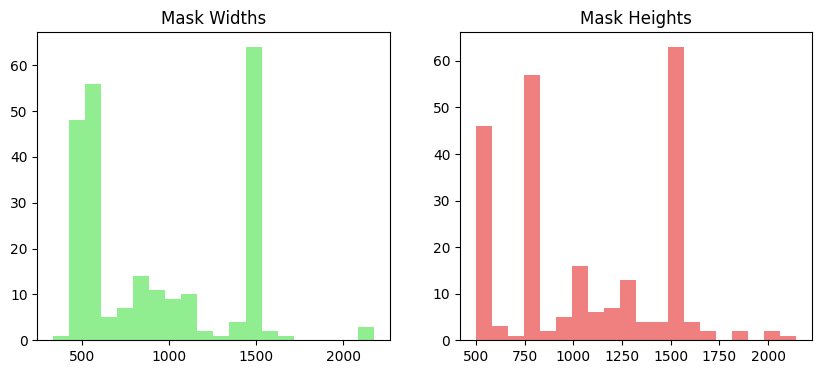

In [12]:
# Mask Sizes

mask_shapes = []
for mask_path in labels_files:
    mat = sio.loadmat(mask_path)
    mask_key = [k for k in mat.keys() if not k.startswith('__')][0]
    mask = mat[mask_key]
    mask_shapes.append(mask.shape)


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist([s[0] for s in mask_shapes], bins=20, color='lightgreen')
plt.title("Mask Widths")

plt.subplot(1,2,2)
plt.hist([s[1] for s in mask_shapes], bins=20, color='lightcoral')
plt.title("Mask Heights")
plt.show()

> Image sizes differ from one another (needs addressing)

# Data preprocessing and normalization

In [13]:
# derive sub-dataset name from filename
df["Dataset"] = df["Filename"].str.split("_").str[0]
print(df[["Filename", "Dataset"]].head())


  Filename Dataset
0  dpath_1   dpath
1  dpath_2   dpath
2  dpath_3   dpath
3  dpath_4   dpath
4  dpath_5   dpath


In [14]:
#  80/10/10 split
rng = np.random.default_rng(42)         
new_split = np.zeros(len(df), dtype=int)

for name, group in df.groupby("Dataset"):
    idx = group.index.to_numpy()
    rng.shuffle(idx)                  

    n = len(idx)
    n_train = int(0.8 * n)
    n_val = int(0.1 * n)
    n_test = n - n_train - n_val         

    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train + n_val]
    test_idx  = idx[n_train + n_val:]

    new_split[train_idx] = 1           
    new_split[val_idx]   = 2            
    new_split[test_idx]  = 3            

df["Split"] = new_split  

split_counts = df["Split"].value_counts().sort_index()
print("Split (80/10/10 per Dataset):")
print(f"Split 1 - Train:      {split_counts.get(1, 0)}")
print(f"Split 2 - Validation: {split_counts.get(2, 0)}")
print(f"Split 3 - Test:       {split_counts.get(3, 0)}")


Split (80/10/10 per Dataset):
Split 1 - Train:      188
Split 2 - Validation: 21
Split 3 - Test:       29


In [15]:
# transformations for images (RGB) and binary masks (0/1)
img_transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),  
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

mask_transform = T.Compose([
    T.Resize((512, 512), interpolation=T.InterpolationMode.NEAREST),
    T.PILToTensor(), 
])

In [16]:
# helper functions for loading an image and a mask from the Lizard dataset
def load_lizard_image(row, img1_dir, img2_dir):
    fname = row["Filename"]

    path1 = os.path.join(img1_dir, fname + ".png")
    path2 = os.path.join(img2_dir, fname + ".png")

    if os.path.exists(path1):
        path = path1
    elif os.path.exists(path2):
        path = path2
    else:
        raise FileNotFoundError(f"Image {fname}.png sa nenašiel ani v {img1_dir}, ani v {img2_dir}")

    img = Image.open(path).convert("RGB")
    return img

def load_lizard_mask(row, labels_dir):
    fname = row["Filename"]
    mat_path = os.path.join(labels_dir, fname + ".mat")
    mat = sio.loadmat(mat_path)
    inst_map = mat["inst_map"]          # 0 = pozadie, >0 = jadro

    mask_np = (inst_map > 0).astype("uint8")  # 0/1
    mask = Image.fromarray(mask_np * 255)     # 0/255
    return mask


In [17]:
# helper function to apply the same random augmentations to image and mask
def apply_augmentations(img, mask, flip_h, flip_v, rotate):
    seed = torch.randint(0, 2**32, (1,)).item()

    torch.manual_seed(seed)
    img = flip_h(img)
    torch.manual_seed(seed)
    mask = flip_h(mask)

    torch.manual_seed(seed)
    img = flip_v(img)
    torch.manual_seed(seed)
    mask = flip_v(mask)

    torch.manual_seed(seed)
    img = rotate(img)
    torch.manual_seed(seed)
    mask = rotate(mask)

    return img, mask

In [18]:
# dataset class for Lizard – binary segmentation (0 = background, 1 = nucleus)
class LizardSegmentationDataset(Dataset):
    def __init__(self, df, split_id, img1_dir, img2_dir, labels_dir,
                 img_transform=None, mask_transform=None, augment=False):
        self.df = df[df["Split"] == split_id].reset_index(drop=True)
        self.img1_dir = img1_dir
        self.img2_dir = img2_dir
        self.labels_dir = labels_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.augment = augment

        self.flip_h = T.RandomHorizontalFlip(p=0.5)
        self.flip_v = T.RandomVerticalFlip(p=0.5)
        self.rotate = T.RandomRotation(degrees=10)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img = load_lizard_image(row, self.img1_dir, self.img2_dir)
        mask = load_lizard_mask(row, self.labels_dir)

        if self.augment:
            img, mask = apply_augmentations(img, mask, self.flip_h, self.flip_v, self.rotate)

        if self.img_transform is not None:
            img = self.img_transform(img)

        if self.mask_transform is not None:
            mask = self.mask_transform(mask)  # [1, H, W], 0/255

        mask = (mask > 0).long()  # -> 0/1, dtype long

        return img, mask

In [19]:
# create train/validation/test datasets according to the predefined Split (1/2/3)
train_ds = LizardSegmentationDataset(
    df=df,
    split_id=1,
    img1_dir=IMG1,
    img2_dir=IMG2,
    labels_dir=LABELS,
    img_transform=img_transform,
    mask_transform=mask_transform,
    augment=True,
)

val_ds = LizardSegmentationDataset(
    df=df,
    split_id=2,
    img1_dir=IMG1,
    img2_dir=IMG2,
    labels_dir=LABELS,
    img_transform=img_transform,
    mask_transform=mask_transform,
    augment=False,
)

test_ds = LizardSegmentationDataset(
    df=df,
    split_id=3,
    img1_dir=IMG1,
    img2_dir=IMG2,
    labels_dir=LABELS,
    img_transform=img_transform,
    mask_transform=mask_transform,
    augment=False,
)

In [20]:
# dataloaders for training and evaluation
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False)

In [21]:
# check batch shapes – prepared for U-Net / transformer
batch_imgs, batch_masks = next(iter(train_loader))
print("Images:", batch_imgs.shape)  
print("Masks: ", batch_masks.shape) 

Images: torch.Size([4, 3, 512, 512])
Masks:  torch.Size([4, 1, 512, 512])


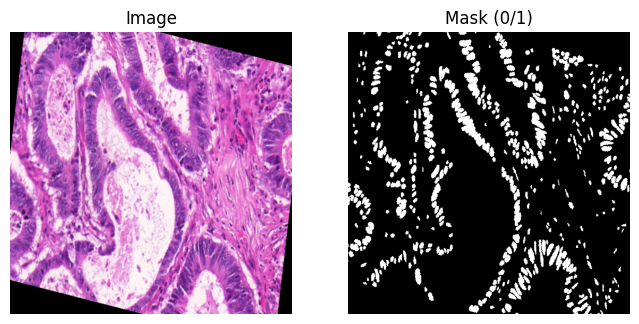

In [22]:
# visualize a single image–mask pair from a training batch
idx = 0

img_np = batch_imgs[idx].permute(1, 2, 0).detach().cpu().numpy()
img_np = (img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

mask_np = batch_masks[idx][0].detach().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.axis("off")
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap="gray")
plt.axis("off")
plt.title("Mask (0/1)")
plt.show()

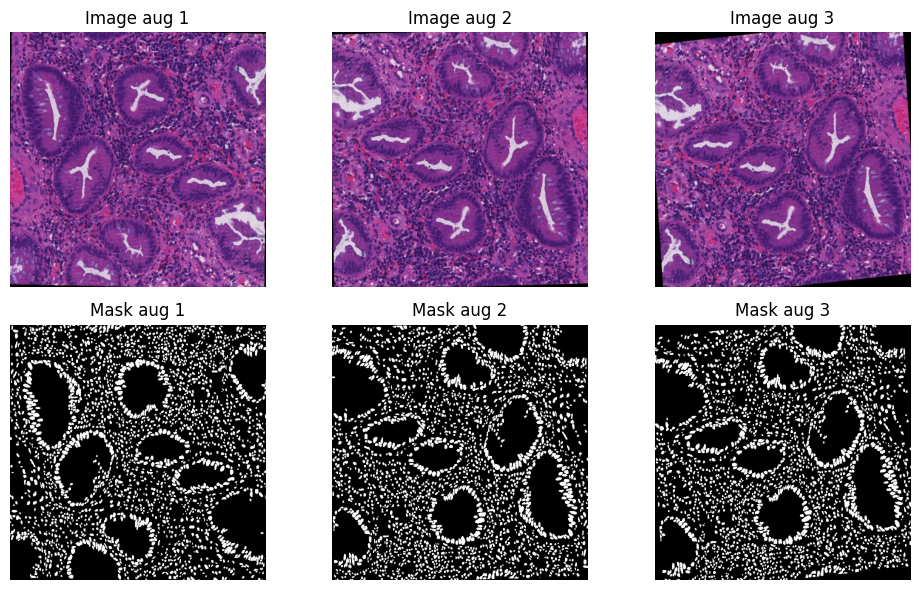

In [23]:
# visualize data augmentations – same sample from train_ds shown multiple times
idx = 0 

fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for i in range(3):
    img, mask = train_ds[idx] 

    img_np = img.permute(1, 2, 0).detach().cpu().numpy()
    img_np = (img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)
    mask_np = mask[0].detach().cpu().numpy()

    axes[0, i].imshow(img_np)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Image aug {i+1}")

    axes[1, i].imshow(mask_np, cmap="gray")
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Mask aug {i+1}")

plt.tight_layout()
plt.show()

# Configuration

In [24]:
# device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU name:", torch.cuda.get_device_name(0))

Using device: cuda
GPU name: NVIDIA GeForce GTX 1650


In [25]:
#random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [26]:
# hyperparameters for the segmentation model
config = {
    "image_size": 512,
    "batch_size": 4,
    "num_epochs": 50,
    "learning_rate": 1e-4,
    "weight_decay": 1e-5,
    "optimizer": "adam",
    "loss": "dice_bce",   
    "model_name": "unet_lizard_baseline",
}

In [27]:
# where to save models, logs and predictions
OUTPUT_DIR = "outputs"
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")
LOG_DIR = os.path.join(OUTPUT_DIR, "logs")
PRED_DIR = os.path.join(OUTPUT_DIR, "predictions")

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)
os.makedirs(PRED_DIR, exist_ok=True)

print("Model dir:", MODEL_DIR)
print("Log dir:", LOG_DIR)
print("Predictions dir:", PRED_DIR)

Model dir: outputs\models
Log dir: outputs\logs
Predictions dir: outputs\predictions


In [28]:
#placeholder for Weights & Biases
use_wandb = False    
wandb_project = "zneus-lizard-segmentation"
wandb_run_name = config["model_name"]

print("W&B enabled:", use_wandb)
print("W&B project:", wandb_project)
print("W&B run name:", wandb_run_name)

W&B enabled: False
W&B project: zneus-lizard-segmentation
W&B run name: unet_lizard_baseline


# Experiments 